In [23]:
import sys
sys.path.append('..')

import os
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import nn

from utils import get_device

## Analyze dataset

In [2]:
texts_df = pd.read_csv('subtaskA_train.csv')

In [3]:
texts_df.head()

,Id,comment_text,conspiratorial
0,0,⚡Se non ci fossero soldati non ci sarebbero gu...,0
1,1,"21/08/21]( [PRE-PRINT]\n\n📄__ ""Shedding of Inf...",1
2,2,PAURA E DELIRIO ALLA CNN: IL MINISTERO DELLA V...,1
3,3,L'Aspirina non aumenta la sopravvivenza dei pa...,0
4,4,L'Italia non puo' dare armi lo vieta la Costit...,0


In [4]:
texts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1842 entries, 0 to 1841
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              1842 non-null   int64 
 1   comment_text    1842 non-null   object
 2   conspiratorial  1842 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 43.3+ KB


In [5]:
texts_df.conspiratorial.value_counts()

1    925
0    917
Name: conspiratorial, dtype: int64

### Test set

In [6]:
texts_df_test = pd.read_csv('subtaskA_test.csv')
texts_df_test.head()

,Id,comment_text
0,0,La CNN ha appena ammesso che Trump non è più a...
1,1,"Notizia del 2017: “Autovelox, la foto viola la..."
2,2,"La foto di due ""sospetti"" in un palazzo non è ..."
3,3,La falsa notizia della bambina con il cartello...
4,4,Ah dimenticavo.. e' gratuita


In [7]:
texts_df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            460 non-null    int64 
 1   comment_text  460 non-null    object
dtypes: int64(1), object(1)
memory usage: 7.3+ KB


## Preprocessing

Remove break line characthers

In [8]:
texts_df.comment_text = texts_df.comment_text.apply(lambda text: text.replace('\n\n', ' ').replace('\n', ' '))
texts_df_test.comment_text = texts_df_test.comment_text.apply(lambda text: str(text).replace('\n\n', ' ').replace('\n', ' '))


## Train-Validation split

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

80-20 train-validation split of the labeled tr dataset

In [10]:
# Split the data into training and testing datasets using stratified sampling
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, eval_index in split.split(texts_df, texts_df.conspiratorial):
    train_df, val_df = texts_df.iloc[train_index], texts_df.iloc[eval_index]

In [11]:
print(train_df.info())
print(train_df.conspiratorial.value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1473 entries, 1509 to 1768
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              1473 non-null   int64 
 1   comment_text    1473 non-null   object
 2   conspiratorial  1473 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 46.0+ KB
None
1    740
0    733
Name: conspiratorial, dtype: int64


In [12]:
print(val_df.info())
print(val_df.conspiratorial.value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369 entries, 361 to 667
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              369 non-null    int64 
 1   comment_text    369 non-null    object
 2   conspiratorial  369 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 11.5+ KB
None
1    185
0    184
Name: conspiratorial, dtype: int64


## Tokenization

In [13]:
from transformers import LlamaTokenizer

In [14]:
tokenizer = LlamaTokenizer.from_pretrained('/home/giacomo/Ai/llama/hgf_weights')

In [15]:
texts_tr = train_df['comment_text']
labels_tr = train_df['conspiratorial'].to_numpy()

texts_val = val_df['comment_text']
labels_val = val_df['conspiratorial'].to_numpy()

texts_test = texts_df_test['comment_text']

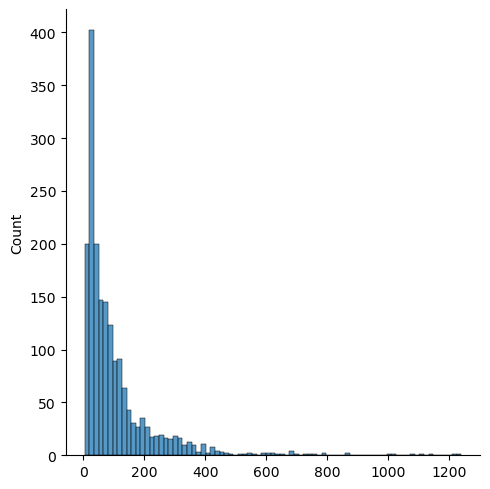

In [16]:
tokenized_len_list = []

for sentence in texts_tr:
    input_ids = tokenizer.encode(sentence, add_special_tokens=True)
    tokenized_len_list.append(len(input_ids))
for sentence in texts_val:
    input_ids = tokenizer.encode(sentence, add_special_tokens=True)
    tokenized_len_list.append(len(input_ids))

sns.displot(tokenized_len_list)
plt.show()

Llama max token length is 2048.

In [17]:
input_ids_tr, input_ids_val, input_ids_test = [], [], []

for sentence in texts_tr:
    tokenized = tokenizer.encode(sentence, return_tensors='pt')
    input_ids_tr.append(tokenized)

for sentence in texts_val:
    tokenized = tokenizer.encode(sentence, return_tensors='pt')
    input_ids_val.append(tokenized)

for sentence in texts_test:
    tokenized = tokenizer.encode(sentence, return_tensors='pt')
    input_ids_test.append(tokenized)

## Llama model

In [18]:
from transformers import LlamaModel

model = LlamaModel.from_pretrained('/home/giacomo/Ai/llama/hgf_weights')

Loading checkpoint shards: 100%|██████████| 2/2 [00:08<00:00,  4.48s/it]
Some weights of the model checkpoint at /home/giacomo/Ai/llama/hgf_weights were not used when initializing LlamaModel: ['lm_head.weight']
- This IS expected if you are initializing LlamaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LlamaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
llama_embeddings_tr, llama_embeddings_val, llama_embeddings_test = [], [], []

llama_embed_folder_pth = 'llama_embeddings'
if not os.path.exists(llama_embed_folder_pth):
    os.makedirs(llama_embed_folder_pth)

Get and save Llama embeddings for traning, validation and test sets.

In [24]:
for input_ids in tqdm(input_ids_tr):
    with torch.no_grad():
        last_hidden_states = model(input_ids)
        # Taking only the last token : [ all sentences (:), only the last position (-1), all hidden unit outputs (:) ]
        llama_embeddings_tr.append(last_hidden_states[0][:, -1, :].numpy())


# Saving the embeddings
np.save(os.path.join(llama_embed_folder_pth, 'llama_embeddings_tr.npy'), llama_embeddings_tr)

100%|██████████| 1473/1473 [1:51:43<00:00,  4.55s/it]  


In [25]:
for input_ids in tqdm(input_ids_val):
    with torch.no_grad():
        last_hidden_states = model(input_ids)
        # Taking only the last token : [ all sentences (:), only the last position (-1), all hidden unit outputs (:) ]
        llama_embeddings_val.append(last_hidden_states[0][:, -1, :].numpy())

# Saving the embeddings
np.save(os.path.join(llama_embed_folder_pth, 'llama_embeddings_val.npy'), llama_embeddings_val)

100%|██████████| 369/369 [26:40<00:00,  4.34s/it] 


In [26]:
for input_ids in tqdm(input_ids_test):
    with torch.no_grad():
        last_hidden_states = model(input_ids)
        # Taking only the last token : [ all sentences (:), only the last position (-1), all hidden unit outputs (:) ]
        llama_embeddings_test.append(last_hidden_states[0][:, -1, :].numpy())

# Saving the embeddings
np.save(os.path.join(llama_embed_folder_pth, 'llama_embeddings_test.npy'), llama_embeddings_test)

100%|██████████| 460/460 [38:56<00:00,  5.08s/it] 


# NN classifier on Llama embeddings

### Generate Dataloaders

In [ ]:
labels_tr = torch.tensor(labels_tr)
labels_val = torch.tensor(labels_val)

In [ ]:
llama_embeddings_tr = torch.tensor(np.load(os.path.join(llama_embed_folder_pth, 'llama_embeddings_tr.npy')))
llama_embeddings_val = torch.tensor(np.load(os.path.join(llama_embed_folder_pth, 'llama_embeddings_val.npy')))
llama_embeddings_test = torch.tensor(np.load(os.path.join(llama_embed_folder_pth, 'llama_embeddings_test.npy')))

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

Wrap data into a TensorDataset

In [ ]:
tr_dataset = TensorDataset(llama_embeddings_tr, labels_tr)
val_dataset = TensorDataset(llama_embeddings_val, labels_val)
test_dataset = TensorDataset(input_ids_test)

Create DataLoaders

In [ ]:
batch_size = 32

tr_dataloader = DataLoader(tr_dataset, sampler=RandomSampler(tr_dataset), batch_size = batch_size)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size = batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size = batch_size)

In [ ]:
# Convert the lists into tensors

input_ids_tr = torch.cat(input_ids_tr, dim=0)
input_ids_val = torch.cat(input_ids_val, dim=0)
input_ids_test = torch.cat(input_ids_test, dim=0)

attention_masks_tr = torch.cat(attention_masks_tr, dim=0)
attention_masks_val = torch.cat(attention_masks_val, dim=0)
attention_masks_test = torch.cat(attention_masks_test, dim=0)

labels_tr = torch.tensor(labels_tr)
labels_val = torch.tensor(labels_val)

: 

## Generate DataLoaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

: 

In [ ]:
tr_dataset = TensorDataset(input_ids_tr, attention_masks_tr, labels_tr)
val_dataset = TensorDataset(input_ids_val, attention_masks_val, labels_val)
test_dataset = TensorDataset(input_ids_test, attention_masks_test)

: 

The DataLoader needs to know our batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

In [ ]:
batch_size = 16

: 

Create the DataLoaders for our training and validation sets. Tr samples are taken in random order, while validation are taken sequentially.

In [ ]:
tr_dataloader = DataLoader(tr_dataset, sampler=RandomSampler(tr_dataset), batch_size = batch_size)

val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size = batch_size)

test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size = batch_size)

: 

## Training Grid Search

In [ ]:
device = get_device()

: 

In [ ]:
print(torch.cuda.memory_summary())

: 

Set save folder for this run

In [ ]:
curr_date = datetime.now()

print(datetime.now())

save_folder_pth = './checkpoints_bert_subtaskA/{}_{}_{}-{}.{}'.format(curr_date.day, curr_date.month, curr_date.year, curr_date.hour, curr_date.minute)
if not os.path.exists(save_folder_pth):
    os.makedirs(save_folder_pth)

: 

Fixed general hyperparams

In [ ]:
max_epochs = 12


# Num batches*num epochs
tr_steps = len(tr_dataloader)*max_epochs

: 

Variable grid searched hyperparams

In [ ]:
lr_list = [1e-6, 2e-6, 3e-6]
warmup_perc_list = [0.1, 0.05] # Percentage of warmup steps for scheduler on the total tr steps
clf_head_list = []

head1 = nn.Sequential(
                nn.Linear(768, 128),
                nn.ReLU(),
                nn.Dropout(0.25),
                nn.Linear(128, 2),
                )
clf_head_list.append((head1, '2_layers_S')) # Each head obeject is composed by a tuple (head, name)

head2 = nn.Sequential(
                nn.Linear(768, 256),
                nn.ReLU(),
                nn.Dropout(0.25),
                nn.Linear(256, 2),
                )
clf_head_list.append((head2, '2_layers_M'))

head3 = nn.Sequential(
                nn.Linear(768, 512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, 32),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(32, 2),
                )
clf_head_list.append((head3, '3_layers_M'))

: 

Initialize, train/eval and save function for each grid search run

In [ ]:
def train_eval_model(lr, warmup_steps, head, model_folder_pth, device):

    torch.cuda.empty_cache()
    #print(torch.cuda.memory_summary())

    # Initialize model
    bert_clf_model, loss_function, optimizer, scheduler = init_bert_clf(tr_steps=tr_steps, lr_rate=lr, scheduler_warmp_steps=warmup_steps, head=head)

    for epoch_i in range(max_epochs):
        print('Epoch: {}'.format(epoch_i))

        # Train
        avg_epoch_loss_tr, acc_score_tr, f1_score_tr, bert_clf_model, optimizer, scheduler = train_clf(bert_clf_model, tr_dataloader, loss_function, optimizer, scheduler, device)


        print('TRAINING | Tr Loss: {} - Tr acc: {} - Tr f1: {}'.format(avg_epoch_loss_tr, acc_score_tr, f1_score_tr))

        # Eval
        avg_epoch_loss_val, acc_score_val, f1_score_val, predictions, labels = eval_clf(bert_clf_model, val_dataloader, loss_function, device)
        print('EVALUATION | Val Loss: {} - Val acc: {} - Val f1: {}'.format(avg_epoch_loss_val, acc_score_val, f1_score_val))

        # Save
        model_save_pth = os.path.join(model_folder_pth, 'bert_clf_{}.pt'.format(epoch_i))
        torch.save({
                    'epoch': epoch_i,
                    'model_state_dict': bert_clf_model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'schdeduler_state_dict': scheduler.state_dict(),
                    'tr_loss': avg_epoch_loss_tr,
                    'val_loss': avg_epoch_loss_val,
                    'tr_acc': acc_score_tr,
                    'val_acc': acc_score_val,
                    'tr_f1': f1_score_tr,
                    'val_f1': f1_score_val,
                    'val_preds': predictions
                    }, model_save_pth)

    torch.cuda.empty_cache()


: 

Grid Search loop

In [ ]:
num_trials = len(lr_list) * len(warmup_perc_list) * len(clf_head_list)
print('Executing {} trials in grid search'.format(num_trials))


for lr in lr_list:
    for clf_head_tuple in clf_head_list:
        for warmup_perc in warmup_perc_list:
            
            # Model save path subfolder
            model_folder_str = 'lr{}_warmup{}_head_{}'.format(lr, warmup_perc, clf_head_tuple[1])
            model_folder_pth = os.path.join(save_folder_pth, model_folder_str)
            if not os.path.exists(model_folder_pth):
                os.makedirs(model_folder_pth)

            print()
            print('Executing model with lr={}, warmup perc.={}, head={}'.format(lr, warmup_perc, clf_head_tuple[1]))

            train_eval_model(lr, warmup_steps=warmup_perc*tr_steps, head=clf_head_tuple[0], model_folder_pth=model_folder_pth, device=device)

           

: 

## Analyze grid search results

In [ ]:
save_folder_pth = './checkpoints_bert_subtaskA/16_4_2023-5.1' # Grid search run to analyze


best_f1_list = []

for lr in lr_list:
    for clf_head_tuple in clf_head_list:
        for warmup_perc in warmup_perc_list:
            
            # Model path subfolder
            model_folder_str = 'lr{}_warmup{}_head_{}'.format(lr, warmup_perc, clf_head_tuple[1])
            model_folder_pth = os.path.join(save_folder_pth, model_folder_str)

            title = 'BERT with lr={}, warmup perc.={}, head={}'.format(lr, warmup_perc, clf_head_tuple[1])

            # Load model checkpoint for each epoch
            val_loss_list, tr_loss_list, val_f1_list, val_acc_list = [], [], [], []

            for epoch_i in range(max_epochs):
                model_pth = os.path.join(model_folder_pth,'bert_clf_{}.pt'.format(epoch_i))
                checkpoint = torch.load(model_pth)
                val_loss_list.append(checkpoint['val_loss'])
                tr_loss_list.append(checkpoint['tr_loss'])
                val_f1_list.append(checkpoint['val_f1'])
                val_acc_list.append(checkpoint['val_acc'])


            best_f1 = max(val_f1_list)
            best_epoch = val_f1_list.index(best_f1)
            best_f1_list.append((title, best_epoch, best_f1))


            plt.figure(figsize=(15,4))

            plt.subplot(1, 2, 1)
            plt.plot(tr_loss_list, label='tr loss', color='green')
            plt.plot(val_loss_list, label='val loss', color='purple')
            plt.xlabel('Epochs')
            plt.legend()

            plt.subplot(1,2,2)
            plt.plot(val_acc_list, label='val accuracy')
            plt.plot(val_f1_list, label='val f1')
            plt.xlabel('Epochs')
            plt.legend()

            plt.suptitle(title)
            plt.show()



: 

In [ ]:
for title, epoch, f1 in best_f1_list:
    print('{} at epoch {}, F1: {:.4f}'.format(title, epoch, f1))

: 

## Choose and predict on test with best model

Best model is: BERT with lr=3e-06, warmup perc.=0.1, head=3_layers_M at epoch 6, F1: 0.8184

In [ ]:
device = get_device()

: 

In [ ]:
final_model_pth = 'checkpoints_bert_subtaskA/16_4_2023-5.1/lr3e-06_warmup0.1_head_3_layers_M/bert_clf_6.pt'

# Recover the best head configuration
head_3_layers_M = nn.Sequential(
                nn.Linear(768, 512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, 32),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(32, 2),
                )
# Initialize and recover model checkpoint
final_model = BertClassifier(head=head_3_layers_M)
final_model.load_state_dict(torch.load(final_model_pth).get('model_state_dict'))

final_model.to(device)

# Prediction on test
test_preds = test_clf(final_model, test_dataloader, device)

: 

In [ ]:
print(test_preds)
# print occurrences of each class
print(np.unique(test_preds, return_counts=True))

: 

Generate result CSV

In [ ]:
id_list = [i for i in range(len(test_preds))]
df = pd.DataFrame({'Id': id_list, 'Expected': test_preds})
df.to_csv('final_bert_submission.csv', index=False)

: 

**RESULTS FROM KAGGLE:**

On the 30% available hidden test set it scores **0.83226**  F1 macro averaged

## Retrain best BERT classifier on whole development set

In [ ]:
from torch.utils.data import ConcatDataset

devel_dataset = ConcatDataset([tr_dataset, val_dataset])
devel_dataloader = DataLoader(devel_dataset, sampler=RandomSampler(devel_dataset), batch_size=batch_size)

: 

In [ ]:
max_epochs = 12
device = get_device()


# Num batches*num epochs
tr_steps = len(devel_dataloader)*max_epochs

# Best params from grid search
lr = 3e-06
warmup_perc = 0.1
head_tuple = (nn.Sequential(
                nn.Linear(768, 512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, 32),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(32, 2),
                ), 'head_3_layers_M')

: 

In [ ]:
curr_date = datetime.now()

retrain_model_folder_pth = './checkpoints_bert_retrain_subtaskA/{}_{}_{}-{}.{}/lr{}_warmup{}_{}'.format(curr_date.day, curr_date.month, curr_date.year, curr_date.hour, curr_date.minute,
                                                                                            lr, warmup_perc, head_tuple[1])
if not os.path.exists(retrain_model_folder_pth):
    os.makedirs(retrain_model_folder_pth)

: 

In [ ]:
print(torch.cuda.memory_summary())

: 

In [ ]:
torch.cuda.empty_cache()

# Initialize model
bert_clf_model, loss_function, optimizer, scheduler = init_bert_clf(tr_steps=tr_steps, lr_rate=lr, scheduler_warmp_steps=warmup_perc*tr_steps, head=head_tuple[0])

for epoch_i in range(max_epochs):
    print('Epoch: {}'.format(epoch_i))

    # Train
    avg_epoch_loss_tr, acc_score_tr, f1_score_tr, bert_clf_model, optimizer, scheduler = train_clf(bert_clf_model, devel_dataloader, loss_function, optimizer, scheduler, device)
    print('RETRAINING | Tr Loss: {} - Tr acc: {} - Tr f1: {}'.format(avg_epoch_loss_tr, acc_score_tr, f1_score_tr))

    # Save
    retrain_model_save_pth = os.path.join(retrain_model_folder_pth, 'bert_retrain_clf_{}.pt'.format(epoch_i))
    torch.save({
                'epoch': epoch_i,
                'model_state_dict': bert_clf_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'schdeduler_state_dict': scheduler.state_dict(),
                'tr_loss': avg_epoch_loss_tr,
                'tr_acc': acc_score_tr,
                'tr_f1': f1_score_tr,
                }, retrain_model_save_pth)


: 

Visualize retrain loss, accuracy and f1

In [ ]:
tr_loss_list, tr_acc_list, tr_f1_list = [], [], []
title = 'Retrain BERT with lr={}, warmup perc.={}, head={}'.format(lr, warmup_perc, head_tuple[1])


for epoch_i in range(max_epochs):
    model_pth = os.path.join(retrain_model_folder_pth,'bert_retrain_clf_{}.pt'.format(epoch_i))
    checkpoint = torch.load(model_pth)
    tr_loss_list.append(checkpoint['tr_loss'])
    tr_acc_list.append(checkpoint['tr_acc'])
    tr_f1_list.append(checkpoint['tr_f1'])


plt.figure(figsize=(15,4))

plt.subplot(1, 2, 1)
plt.plot(tr_loss_list, label='retrain loss', color='green')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(tr_acc_list, label='retrain accuracy')
plt.plot(tr_f1_list, label='retrain f1')
plt.xlabel('Epochs')
plt.legend()

plt.suptitle(title)
plt.show()

: 

### Choose and predict on test with best epoch checkpoint of retrain

In [ ]:
device = get_device()

: 

In [ ]:
final_retrain_model_pth = 'checkpoints_bert_retrain_subtaskA/19_4_2023-14.27/lr3e-06_warmup0.1_head_3_layers_M/bert_retrain_clf_7.pt'

# Recover the best head configuration
head_3_layers_M = nn.Sequential(
                nn.Linear(768, 512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, 32),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(32, 2),
                )
# Initialize and recover model checkpoint
final_model_retrain = BertClassifier(head=head_3_layers_M)
final_model_retrain.load_state_dict(torch.load(final_retrain_model_pth).get('model_state_dict'))

final_model_retrain.to(device)

# Prediction on test
test_preds = test_clf(final_model_retrain, test_dataloader, device)

: 

In [ ]:
print(test_preds)
# Print occurrences of each class
print(np.unique(test_preds, return_counts=True))

: 

Generate result CSV

In [ ]:
id_list = [i for i in range(len(test_preds))]
df = pd.DataFrame({'Id': id_list, 'Expected': test_preds})
df.to_csv('final_bert_retrain_submission.csv', index=False)

: 

Check % of diff with final submission without retrain to estimate the range of the retrain test score

In [ ]:
bert_submission_retrain = test_preds

bert_submission_no_retrain = pd.read_csv('final_bert_submission.csv')['Expected'].to_numpy()
perc_diff = np.sum(bert_submission_no_retrain != bert_submission_retrain)/len(bert_submission_retrain)

print('Percentual difference between retrain and no retrain test submission: {}%'.format(perc_diff*100))    

: 

**RESULTS FROM KAGGLE:**

On the 30% available hidden test set it scores **0.77478**  F1 macro averaged